In [1]:
from matplotlib.pyplot import axes
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


def prepare_data(
    dataset,
    num_imgs=10,
    preprocess_sensory=True,
    noise_level="medium",
):
    import torch
    import random

    data = dataset.data
    # print(num_imgs)
    # print(data.shape)
    data = data.reshape(data.shape[0], -1)
    # print(data.shape)
    data = torch.tensor(data[:num_imgs]).float().to(device)
    # print(data.shape)

    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        data = (data - data.mean()) / data.std()
        # print(mnist_data[0])

    # noissing the data
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise

    return data, noisy_data

In [2]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
from matrix_initializers import SparseMatrixByScalingInitializer
from vectorhash_functions import solve_mean, spacefillingcurve
import math
from scipy.stats import norm


def test_memory_capacity(
    data,
    noisy_data,
    shapes=[(3, 3, 5), (4, 4, 7)],
    N_h=1000,
    initalization_method="by_scaling",
    percent_nonzero_relu=0.01,
    W_gh_var=1.0,
    sparse_initialization=0.1,
    T=0.01,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    learned_pseudo=True,
    plot_figs=False,
):
    assert initalization_method in ["by_scaling", "by_sparsity"]

    if initalization_method == "by_scaling":
        W_hg_std = math.sqrt(W_gh_var)
        W_hg_mean = (
            -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(shapes))
        )
        h_normal_mean = len(shapes) * W_hg_mean
        h_normal_std = math.sqrt(len(shapes)) * W_hg_std
        relu_theta = 0
    elif initalization_method == "by_sparsity":
        gamma = 1 - sparse_initialization
        relu_theta = math.sqrt(gamma * len(shapes)) * norm.ppf(1 - percent_nonzero_relu)
        W_hg_mean = 0
        W_hg_std = math.sqrt(gamma * len(shapes))
        h_normal_mean = -relu_theta
        h_normal_std = (1 - sparse_initialization) * len(shapes)

    GS = GridScaffold(
        shapes=shapes,
        N_h=N_h,
        input_size=data.shape[1],
        device=device,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        sparse_matrix_initializer=(
            SparseMatrixByScalingInitializer(
                mean=W_hg_mean, scale=W_hg_std, device=device
            )
            if initalization_method == "by_scaling"
            else SparseMatrixBySparsityInitializer(
                sparsity=sparse_initialization, device=device
            )
        ),
        relu_theta=relu_theta,
        T=T,
        continualupdate=continualupdate,
        ratshift=ratshift,
        initialize_W_gh_with_zeroes=initialize_W_gh_with_zeroes,
        pseudo_inverse=pseudo_inverse,
        learned_pseudo=learned_pseudo,
        epsilon=0.01,
        use_h_fix=True,
    )

    # learn over all images
    v = spacefillingcurve(shapes)

    GS.learn_path(observations=data, velocities=v[: len(data)])
    # print(len(v[: len(data)]))
    recalled_imgs = GS.recall(noisy_data)
    # if plot_figs:
    #     for i in range(len(data)):
    #         original_img = data[i].reshape(28, 28).cpu().numpy()
    #         noisy_img = noisy_data[i].reshape(28, 28).cpu().numpy()
    #         recalled_img = recalled_imgs[i].reshape(28,28).cpu().numpy()
    #         print_imgs_side_by_side(
    #             original_img,
    #             noisy_img,
    #             recalled_img,
    #             out=f"mnist_test_2/{len(data)}shitty{i}.png",
    #             captions=["original", "noisy", "recalled"],
    #             title="Learned",
    #         )

    similarity = torch.nn.functional.cosine_similarity(data, recalled_imgs)
    return similarity
    # return GS.H - GS.mean_h

Recreating Capacity Results

In [3]:
# Memory Capacity Tests
import torchvision
from torchvision import transforms
import torch

shapes = [(3, 3), (4, 4), (5, 5)]
# shapes = [(5, 5), (9, 9), (11, 11)]

N_h = 10000

N_g = 0
for shape in shapes:
    l = torch.prod(torch.tensor(shape)).item()
    N_g += l
# print("N_g", N_g)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.CIFAR100(
#   root="data", train=True, download=True, transform=transform
# )

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST

percents = [
    0.5,
    # 0.01,  # 1
    # 0.03,  # 2
    # 0.1,  # 3
    # 0.2,  # 4
    # 0.33,  # 5
    # 0.5,  # 6
    # 0.75,  # 7
    # 0.9,  # 8
    # 1.0,  # 9
    # 1.1,  # 10
    # 1.5,  # 11
    # 2.0,  # 12
    # 3.0,  # 13
    # 10.0,  # 14
]

num_images = [theoretical_capacity * p for p in percents]
num_images = [math.ceil(n) for n in num_images]
print(num_images)

preprocess_sensory = True
noise_level = "none"

# TODO: Need a hyperparam N_p for dimension of the projection from grid cells to place cells
similarities = []
for num_imgs in num_images:
    print("==========================================")
    data, noisy_data = prepare_data(
        dataset,
        num_imgs=num_imgs,
        preprocess_sensory=preprocess_sensory,
        noise_level=noise_level,
    )
    similarity = test_memory_capacity(
        data,
        noisy_data,
        shapes=shapes,
        N_h=N_h,
        initalization_method="by_scaling",
        percent_nonzero_relu=0.8,  # 800 / N_h,
        W_gh_var=1.0,
        sparse_initialization=0,
        T=0.01,
        continualupdate=False,
        ratshift=False,
        initialize_W_gh_with_zeroes=False,
        pseudo_inverse=False,
        learned_pseudo=True,
        plot_figs=True,
    )
    print("Cosine Similarity", torch.mean(similarity).item())
    similarities.append(similarity)

[319]
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  10000


/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_62870/3236438726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


image 1
Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 9749.0
avg nonzero H_denoised: 9749.0
first H is G 0 times W_hg tensor([True, True, True,  ..., True, True, True])
tensor([1.0000])
G = G_ tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])
G = first g tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, 

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:509: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ self.inhibition_matrix_hs @ input


Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 10000.0
avg nonzero H_denoised: 9759.0
first H is G 0 times W_hg tensor([True, True, True,  ..., True, True, True])
tensor([0.9476])
G = G_ tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])
G = first g tensor([[False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, 

Comparing initialization techniques (at 10%, 50%, 100%, 150% capacity)

Compare continual learning vs learning once at start (at 10%, 50%, 100%, 150% capacity)

Hyperparam tuning for number active hippocampal cells after denoising

Testing valididy and recall of learned pseudoinverse

In [4]:
# Init of psuedo inverse calculation
import torchvision
from torchvision import transforms
import torch
from torch import nn


class PsuedoInverse:
    def __init__(self, N_h, input_size, epsilon=0.01, device="cpu"):
        self.N_h = N_h
        self.input_size = input_size
        self.epsilon = epsilon
        self.device = device

        self.inhibition_matrix_sh = torch.eye(self.N_h, device=device) / (N_h)
        self.inhibition_matrix_hs = torch.eye(self.input_size, device=device) / (
            input_size
        )

        # INITIALIZATION OF HIDDEN LAYER MAGIC

        self.lin1HS = nn.Linear(input_size, 10 * input_size)
        self.activationHS = nn.LogSigmoid()
        torch.nn.init.uniform_(self.lin1HS.weight, -0.5, 0.5)

        self.lin1SH = nn.Linear(N_h, 10 * N_h)
        self.activationSH = nn.LogSigmoid()
        torch.nn.init.uniform_(self.lin1HS.weight, -0.5, 1 / 2)

        self.W_sh = torch.zeros((self.input_size, self.N_h), device=device)
        self.W_hs = torch.zeros((self.N_h, self.input_size), device=device)

    def hiddenlayer(self, input, learned="hs"):
        if learned == "hs":
            hidden = self.activationHS(self.lin1HS(input))
        else:
            hidden = self.activationSH(self.lin1SH(input))
        return hidden

    def calculatepseudoinverse(self, input, output, input_size, learned="hs"):
        inhibition = (
            self.inhibition_matrix_hs if learned == "hs" else self.inhibition_matrix_sh
        )
        W = self.W_hs if learned == "hs" else self.W_sh

        bk = (inhibition @ input) / (1 + input.T @ inhibition @ input)

        # ERROR VECTOR EK
        E_k = output - W @ input

        # NORMALIZATION FACTOR

        E = ((E_k.T @ E_k) / input_size) / (1 + input.T @ inhibition @ input)
        L2Enorm = torch.abs(E)

        # GAMMA CALCULATION

        gamma = 1 / (1 + ((1 - torch.exp(-L2Enorm)) / self.epsilon))

        inhibition = inhibition - inhibition * input @ bk.T
        # ((1-torch.exp(-L2Enorm))/self.epsilon) * torch.eye(input_size, device=self.device)

        if learned == "hs":
            self.inhibition_matrix_hs = inhibition
            self.W_hs += torch.outer((output - W @ input), bk.T)
        else:
            self.inhibition_matrix_sh = inhibition
            self.W_sh += torch.outer((output - W @ input), bk.T)

    def learnprojection(self, input, output, learned="hs"):
        # input: (N)
        # output: (M)
        # M: (M x N)
        # Eg : Wgh = 1/Nh * sum_i (G_i * H_iT) (outer product)
        ret = (torch.einsum("j,i->ji", output, input)) / (
            # self.N_h
            torch.linalg.norm(input + 1e-10)
            ** 2
        )
        if learned == "hs":
            self.W_hs += ret
        else:
            self.W_sh += ret

    def learn(self, input, output, learned="hs"):

        # input = self.hiddenlayer(input, learned)

        self.calculatepseudoinverse(input, output, self.input_size, learned)

    def recall(self, input, used="hs"):
        W = self.W_hs if used == "hs" else self.W_sh
        # return W @ self.hiddenlayer(input, used)
        return W @ input

In [5]:
import torchvision
from torchvision import transforms
import torch

shapes = [(3, 3), (4, 4), (5, 5)]
# shapes = [(5, 5), (9, 9), (11, 11)]

N_h = 1000

N_g = 0
for shape in shapes:
    l = torch.prod(torch.tensor(shape)).item()
    N_g += l
# print("N_g", N_g)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# dataset = torchvision.datasets.FashionMNIST(
#     root="data", train=True, download=True, transform=transform
# )

# dataset = torchvision.datasets.CIFAR100(
#   root="data", train=True, download=True, transform=transform
# )

input_size = 1
for shape in dataset.data[0].shape:
    input_size *= shape

theoretical_capacity = N_g * N_h / input_size  # 784 is the size of the input for MNIST


num_images = 100
print(num_images)

preprocess_sensory = True
noise_level = "none"
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_images,
    preprocess_sensory=preprocess_sensory,
    noise_level=noise_level,
)
H = test_memory_capacity(
    data,
    data,
    shapes=shapes,
    N_h=N_h,
    initalization_method="by_scaling",
    percent_nonzero_relu=900 / N_h,
    W_gh_var=1.0,
    sparse_initialization=0,
    T=0.01,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    learned_pseudo=False,
    plot_figs=False,
)

100
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000


/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_62870/3236438726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


image 1
Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 898.0
avg nonzero H_denoised: 898.0
first H is G 0 times W_hg tensor([ True,  True, False,  True, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False, False,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, 

In [6]:
pseudoinverse = PsuedoInverse(N_h=1000, input_size=784, epsilon=0.01)
n = 100
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

data, noisydata = prepare_data(
    dataset,
    num_imgs=n,
    preprocess_sensory=True,
    noise_level="medium",
)


for i in range(1):
    for i in range(n):
        pseudoinverse.learn(data[i], H[i], learned="hs")
        pseudoinverse.learn(H[i], data[i], learned="sh")

img_reconstruction = []
H_reconstruction = []
recompfromboth = []

print("RECALL")
for i in range(n):
    recompfromboth.append(
        torch.cosine_similarity(
            data[i],
            pseudoinverse.recall(
                input=pseudoinverse.recall(input=data[i], used="hs"), used="sh"
            ),
            dim=0,
        )
    )
    # append(torch.cosine_similarity(H[i], pseudoinverse.recall(input=noisydata[i], used="hs"), dim=0))
    H_reconstruction.append(
        torch.cosine_similarity(
            H[i], pseudoinverse.recall(input=data[i], used="hs"), dim=0
        )
    )
    img_reconstruction.append(
        torch.cosine_similarity(data[i], pseudoinverse.recall(H[i], used="sh"), dim=0)
    )

print("Data mean", torch.mean(torch.tensor(data)))
print("H mean", torch.mean(torch.tensor(H)))
print("Num images", n)
print("H Reconstruction", torch.mean(torch.tensor(H_reconstruction)))
print("Img Reconstruction", torch.mean(torch.tensor(img_reconstruction)))
print("Recomp from both", torch.mean(torch.tensor(recompfromboth)))

/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_62870/3236438726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


RuntimeError: both arguments to matmul need to be at least 1D, but they are 2D and 0D

/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_23139/3236438726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:num_imgs]).float().to(device)


module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1000
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 1.],
        [0., 1.]])
H tensor([1.9299e+00, 0.0000e+00, 9.5001e-01, 2.2918e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.8733e-01, 0.0000e+00, 5.9346e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.7375e-01, 0.0000e+00, 6.5323e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0252e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.3483e-01, 1.0665e+00, 0.0000e+00, 1.1229e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 7.1985e-01, 0.0000e+00, 0.0000e+00,
        2.1045e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8207e+00,
        3.5408e-01, 3.7692e-02, 0.0000e+00, 0.0000e+00,

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:492: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ self.inhibition_matrix_hs @ input
/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_23139/114494509.py:114: UserWarning: Using a target size (torch.Size([1, 784])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("loss:", torch.nn.functional.mse_loss(s, s_rec).item())


TypeError: 'Axes' object is not subscriptable

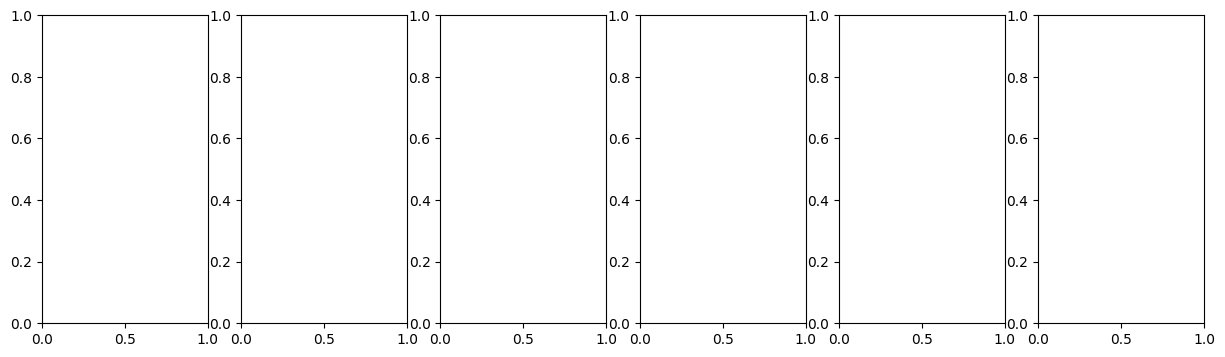

In [4]:
import torchvision
from torchvision import transforms
import torch
import math
import numpy as np
from matrix_initializers import ConstantInitializer, SparseMatrixByScalingInitializer
from vectorhash_functions import solve_mean, spacefillingcurve
from nd_scaffold import GridScaffold
from graph_utils import print_imgs_side_by_side
import matplotlib.pyplot as plt
import os
import torchvision
from torchvision import transforms
from scipy.stats import norm

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
data, noisy_data = prepare_data(
    dataset,
    num_imgs=100,
    preprocess_sensory=True,
    noise_level="none",
)

T = 1e-3
device = "cpu"
shapes = [(3, 3), (4, 4), (5, 5)]
N_h = 1000
target_N_h = 300
percent_nonzero_relu = target_N_h / N_h

W_hg_std = 1
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(shapes))
h_normal_mean = len(shapes) * W_hg_mean
h_normal_std = math.sqrt(len(shapes)) * W_hg_std

const = ConstantInitializer(
    value=GridScaffold(
        shapes=shapes,
        N_h=N_h,
        input_size=data.shape[1],
        device=device,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        sparse_matrix_initializer=SparseMatrixByScalingInitializer(
            mean=W_hg_mean, scale=W_hg_std, device=device
        ),
        relu_theta=0,
        T=T,
        use_h_fix=True,
        learned_pseudo=True,
        initialize_W_gh_with_zeroes=False,
    ).W_hg
)

GS = GridScaffold(
    shapes=shapes,
    N_h=N_h,
    input_size=data.shape[1],
    device=device,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    sparse_matrix_initializer=const,
    relu_theta=0,
    T=T,
    use_h_fix=True,
    learned_pseudo=True,
    initialize_W_gh_with_zeroes=False,
)
GS2 = GridScaffold(
    shapes=shapes,
    N_h=N_h,
    input_size=data.shape[1],
    device=device,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    sparse_matrix_initializer=const,
    relu_theta=0,
    T=T,
    use_h_fix=False,
    learned_pseudo=True,
    initialize_W_gh_with_zeroes=False,
)


# GS.learn_path(observations=data, velocities=v[: len(data)])
# recalled_imgs = GS.recall(noisy_data)
# similarity = torch.nn.functional.cosine_similarity(data, recalled_imgs)
# print(torch.mean(similarity).item())

v = spacefillingcurve(shapes)
print(torch.vstack(v))
k = 0

GS.learn(data[k], velocity=v[k])
GS2.learn(data[k], velocity=v[k])
print(k)
k += 1

for i in range(0, k):
    print(i)
    s = data[i]
    h = GS.hippocampal_from_sensory(s)
    g = GS.grid_from_hippocampal(h)
    g_rec = GS.denoise(g)
    h_rec = GS.hippocampal_from_grid(g_rec)
    s_rec = GS.sensory_from_hippocampal(h_rec - GS.mean_h)
    print(g_rec)
    print("h_mean:", (h_rec.mean() - GS.mean_h).item())
    print("loss:", torch.nn.functional.mse_loss(s, s_rec).item())
    print("similarity:", torch.cosine_similarity(s, s_rec).mean().item())


fig, ax = plt.subplots(k, 6, figsize=(15, 4 * k))
for j in range(0, k):
    h1 = GS.hippocampal_from_sensory(data[j])
    h2 = GS2.hippocampal_from_sensory(data[j])

    recovered_s1 = GS.sensory_from_hippocampal(h1 - GS.mean_h)
    recovered_s2 = GS2.sensory_from_hippocampal(h2)

    g_recovered_s1 = GS.grid_from_hippocampal(h1)
    g_recovered_s2 = GS2.grid_from_hippocampal(h2)

    g_recovered_s1_1 = GS.sensory_from_hippocampal(
        (GS.hippocampal_from_grid(GS.denoise(g_recovered_s1))) - GS.mean_h
    )
    g_recovered_s1_2 = GS2.sensory_from_hippocampal(
        (GS2.hippocampal_from_grid(GS2.denoise(g_recovered_s2)))
    )

    ax[j][0].imshow(data[j].reshape(28, 28).cpu().numpy())
    ax[j][0].set_title(f"s{j}")
    ax[j][1].imshow(recovered_s1.reshape(28, 28).cpu().numpy())
    ax[j][1].set_title("s -> h -> s")
    ax[j][2].imshow(recovered_s2.reshape(28, 28).cpu().numpy())
    ax[j][2].set_title("s -> h -> s\n (no fix)")
    ax[j][3].imshow(g_recovered_s1_1.reshape(28, 28).cpu().numpy())
    ax[j][3].set_title("s -> h -> g -> denoised g -> h -> s")
    ax[j][4].imshow(g_recovered_s1_2.reshape(28, 28).cpu().numpy())
    ax[j][4].set_title("s -> h -> g -> denoised g -> h -> s \n(no fix)")
    ax[j][5].imshow(
        (
            -g_recovered_s1_1 / g_recovered_s1_1.mean()
            + g_recovered_s1_2 / g_recovered_s1_2.mean()
        )
        .reshape(28, 28)
        .cpu()
        .numpy()
    )
    ax[j][5].set_title("diff")

    plt.show()

    fig.savefig("test_fix_4.png")